# Baseline solution
We use this [dataset](https://www.kaggle.com/datasets/mariomatos/image-colorization?resource=download) to train the neural network. Our baseline is based on Unet architecture. We will use Lab colorspace to produce inputs and outputs of the network. This will drastically simplify prediction process as we do not have to care about predicting the structure of the picture. Also, it allows to reduce the number of parameters making training and inference faster.

In [6]:
import os
import cv2
import torch
import torchvision
import tqdm
# root_dir = '/content/drive/MyDrive/Innopolis/2022Fall/PMLDL/Image inpainting'
# os.chdir(root_dir)

In [3]:
!unzip archive.zip

Archive:  archive.zip
replace unlabeled2017_subsample/000000010032.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Loading dataset

In [7]:
class ImageColorizationDataset(torch.utils.data.Dataset):
    def __init__(self, path, transforms):
        super().__init__()
        self.transforms = transforms
        self.labels = []
        for root, _, files in os.walk(path):
            for image in files:
                img = cv2.imread(root + '/' + image)
                img = cv2.resize(img, (128, 128))
                self.labels.append(img)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_lab = cv2.cvtColor(label, cv2.COLOR_RGB2Lab)
        inp = img_lab[:, :, 0] # Extract luma
        label = img_lab[:, :, 1:] # Extract a & b components
        return self.transforms(inp), torchvision.transforms.ToTensor()(label)

    def __len__(self):
        return len(self.labels)

In [8]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

dataset = ImageColorizationDataset('unlabeled2017_subsample/', transforms)

BATCH_SIZE = 16
dataloader = torch.utils.data.DataLoader(dataset, BATCH_SIZE)

## Defining a model
As I mentioned, our model is based on U-net architecture. It takes luminosity and produces a and b color differences.

In [9]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_ch, out_ch, kernel_size)
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(out_ch, out_ch, kernel_size)
        self.relu2 = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        return x

class DownsapmlingBlock(torch.nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3):
        super().__init__()
        self.conv = ConvBlock(in_ch, out_ch, kernel_size)
        self.pooling = torch.nn.MaxPool2d(2)

    def forward(self, x):
        x = self.pooling(x)
        x = self.conv(x)
        return x

class UpsamplingBlock(torch.nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = torch.nn.ConvTranspose2d(in_ch, in_ch // 2, 2, 2)
        self.conv = ConvBlock(in_ch, out_ch)

    def forward(self, x, x_skip):
        x = self.up(x)
        
        diffY = x_skip.size()[2] - x.size()[2]
        diffX = x_skip.size()[3] - x.size()[3]

        x = torch.nn.functional.pad(x, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x_skip, x], dim=1)
        return self.conv(x)


class Unet(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.init = ConvBlock(channels[0], channels[1])
        self.down1 = DownsapmlingBlock(channels[1], channels[2])
        self.down2 = DownsapmlingBlock(channels[2], channels[3])
        self.down3 = DownsapmlingBlock(channels[3], channels[4])

        self.up1 = UpsamplingBlock(channels[4], channels[3])
        self.up2 = UpsamplingBlock(channels[3], channels[2])
        self.up3 = UpsamplingBlock(channels[2], channels[1])
        self.out = torch.nn.Conv2d(channels[1], 2, kernel_size=1)

    def forward(self, x):
        x = self.init(x)
        x_init = x
        x = self.down1(x)
        x_1 = x
        x = self.down2(x)
        x_2 = x
        x = self.down3(x)

        x = self.up1(x, x_2)
        x = self.up2(x, x_1)
        x = self.up3(x, x_init)
        x = self.out(x)

        x = torch.nn.functional.interpolate(x, 128)

        return x

In [10]:
model = Unet([1, 64, 128, 256, 512])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Unet(
  (init): ConvBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU()
  )
  (down1): DownsapmlingBlock(
    (conv): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (relu1): ReLU()
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (relu2): ReLU()
    )
    (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): DownsapmlingBlock(
    (conv): ConvBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (relu1): ReLU()
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (relu2): ReLU()
    )
    (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down3): DownsapmlingBlock(
    (conv): ConvBlock(
      (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
      (relu1): ReLU()
 

## Training neural network

In [ ]:
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

def epoch(model, dataloader, loss, optimizer, device):
    total_mse = 0
    n_samples = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        prediction = model(x)
        l = loss(prediction, y)
        l.backward()
        optimizer.step()
        total_mse += l.item()
        n_samples += x.shape[0]
    scheduler.step()
    mean_mse = total_mse / n_samples
    print(f'Mean MSE: {mean_mse}')
    return mean_mse

EPOCHS = 100
TOLERANCE = 10
last_mse = 1000
cnt = 0
for e in range(EPOCHS):
    print(f'Epoch {e}:')
    mean_mse = epoch(model, dataloader, loss, optimizer, device)
    if mean_mse >= last_mse:
        cnt += 1
    if mean_mse < last_mse:
        cnt = 0
        last_mse = mean_mse
        torch.save(model, 'baseline.pt')
    if cnt > TOLERANCE:
        break

Epoch 0:


(262, 1042, 3)


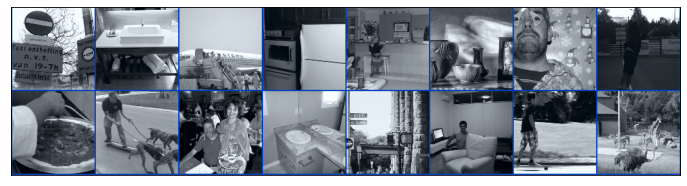

In [22]:
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams['figure.figsize'] = (12, 12)

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        img = np.asarray(img)
        print(img.shape)
        img = cv2.cvtColor(img, cv2.COLOR_Lab2RGB)
        axs[0, i].imshow(img)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

model = Unet([1, 64, 128, 256, 512])
model = torch.load('baseline.pt')
model.to(device)
model.eval()
inp, _ = next(iter(dataloader))
predictions = model(inp.to(device)).cpu()
result = torch.cat([inp, predictions], dim=1)
grid = torchvision.utils.make_grid(result)
show(grid)